## Detection algorithm 

In [1]:
#-*- coding=utf-8 -*-
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as LA
from os import listdir
from os.path import isfile, join
from datetime import datetime
import os, sys, errno
import threading
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from CarDetection_Module.Car_Detection import Car_Detection 
from CarDetection_Module.detect_algorithm import detect_algorithm

%matplotlib inline


#################### function list ###################
def check_file_path_exist(csvName):
    if not os.path.exists(os.path.dirname(csvName)):
        try:
            os.makedirs(os.path.dirname(csvName))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def get_mag_len(df, mag_number):
    for i in range(mag_number):
        df["Mag" + str(i+1) + "_Len"] = (df["Mag" + str(i+1) +"_X"].pow(2) + df["Mag" + str(i+1) +"_Y"].pow(2) + df["Mag" + str(i+1) +"_Z"].pow(2) ).pow(0.5)
    return df

def get_mag_env(df, mag_number, offset_points):
#     for i in range(mag_number):
#         df["Mag" + str(i+1) + "_EnvX"] = df["Mag" + str(i+1) +"_X"][:offset_points].mean()
#         df["Mag" + str(i+1) + "_EnvY"] = df["Mag" + str(i+1) +"_Y"][:offset_points].mean()
#         df["Mag" + str(i+1) + "_EnvZ"] = df["Mag" + str(i+1) +"_Z"][:offset_points].mean()
    for i in range(mag_number):
        df["Mag" + str(i+1) + "_EnvX"] = df["EnvMag" + str(i+1) +"_X"]
        df["Mag" + str(i+1) + "_EnvY"] = df["EnvMag" + str(i+1) +"_Y"]
        df["Mag" + str(i+1) + "_EnvZ"] = df["EnvMag" + str(i+1) +"_Z"]

    return df

def get_mag_car_field(df, mag_number):
    for i in range(mag_number):
        df["Mag" + str(i+1) + "_CarX"] = df["Mag" + str(i+1) +"_X"] - df["Mag" + str(i+1) + "_EnvX"]
        df["Mag" + str(i+1) + "_CarY"] = df["Mag" + str(i+1) +"_Y"] - df["Mag" + str(i+1) + "_EnvY"]
        df["Mag" + str(i+1) + "_CarZ"] = df["Mag" + str(i+1) +"_Z"] - df["Mag" + str(i+1) + "_EnvZ"]
        df["Mag" + str(i+1) + "_CarLen"] = (df["Mag" + str(i+1) +"_CarX"].pow(2) + df["Mag" + str(i+1) +"_CarY"].pow(2) + df["Mag" + str(i+1) +"_CarZ"].pow(2) ).pow(0.5)
    return df    

def get_car_brand(df, brand, category):
    df["Brand"] = brand
    df["Category"] = category
    df = df[sorted(df.columns)]
    return df 

def get_car_in_out_type(df, in_out_type):
    d_zeros = pd.DataFrame(np.zeros(df.shape[0], ))
    d_ones  = pd.DataFrame(np.ones (df.shape[0], ))

    if 'Forward' not in df.columns:
        df.insert(2, "Forward", d_zeros) 
        df.insert(3, "Backward", d_zeros) 
        df.insert(4, "Sideway", d_zeros) 
    
    else:
        df['Forward'].replace(0,inplace=True) 
        df['Backward'].replace(0,inplace=True) 
        df['Sideway'].replace(0,inplace=True) 

    if in_out_type == "Forward":
        df['Forward']  = 1
    elif in_out_type == "Backward":
        df["Backward"] = 1
    elif in_out_type == "Sideway":
        df["Sideway"]  = 1
    else:
        print("car_in_out_type : error input")
    return df 

def get_kmean_label(df, feature):
    random_state = 170
    X_filtered = df[feature].as_matrix()
    Kmean_model = KMeans(n_clusters=3, random_state=random_state)
    y_pred = Kmean_model.fit_predict(X_filtered)
    if "Class_Target" in df.columns:
        df["Class_Target"].replace(y_pred,inplace=True) 
        df["Class"].replace( y_pred * df["Mag1_CarLen"].max()/2,inplace=True) 
    else:
        df["Class_Target"] = y_pred 
        df["Class"] = y_pred * df["Mag1_CarLen"].max()/2
    print("Cluster centers ", Kmean_model.cluster_centers_ )
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X_filtered[:,0], X_filtered[:,1], X_filtered[:,2], c=y_pred)
    plt.title('Mag scatter plot with car')
    plt.xlabel('MagX')
    plt.ylabel('MagY')
    plt.show()
    return df


################ Romdam Forest ##########################################
def set_Training_RandomForest(trainDataFrame, targetingDataFrame):
    X_train, X_test, y_train, y_test = train_test_split(trainDataFrame, targetingDataFrame, test_size=0.30, random_state=30)
    model = RandomForestClassifier(n_estimators=100, max_depth=5)
    model.fit(X_train, y_train)
    print('Test Model Score: ',model.score(X_test, y_test) )
#     print('Model Parameter: ',model.get_params )
#     print('Cross Validation Score', np.mean(cross_val_score(model, X_train, y_train, cv=10)))
    print("Click Rate: ",targetingDataFrame.sum()/len(targetingDataFrame)*100, "%")
    return model

def set_Training_LogisticRegression(trainDataFrame, targetingDataFrame):
    X_train, X_test, y_train, y_test = train_test_split(trainDataFrame, targetingDataFrame, test_size=0.30, random_state=30)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    print('Test Model Score: ',model.score(X_test, y_test) )
#     print('Model Parameter: ',model.get_params )
#     print('Cross Validation Score', np.mean(cross_val_score(model, X_train, y_train, cv=10)))
    print("Click Rate: ",targetingDataFrame.sum()/len(targetingDataFrame)*100, "%")
    return model

def get_FeatureImportance(model, featureName, important_rate = 0):
    important_feature = []
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
#     for f in range(len(featureName)):
#         print("%d. feature %d - %s (%f)" % (f + 1, indices[f], featureName[indices[f]], importances[indices[f]]))
    for f in range(len(featureName)):
        if importances[indices[f]] >= important_rate:
            print("%d. feature %d - %s (%f)" % (f + 1, indices[f], featureName[indices[f]], importances[indices[f]]))
            important_feature.append(featureName[indices[f]])
    return important_feature
            
def get_FeatureImportance_Boxplot(model, featureName):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    featureLenght = len(featureName)
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(featureLenght), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(featureLenght), indices)
    plt.xlim([-1, featureLenght])
    plt.show()

In [2]:
Rawdata_folderName = os.getcwd() + '/Detection_Database/Raw2/'
Newdata_folderName = os.getcwd() + '/Detection_Database/New2/'
Prasedata_folderName = os.getcwd() + '/Detection_Database/SperateNode/'
check_file_path_exist(Rawdata_folderName)
check_file_path_exist(Prasedata_folderName)

csvFiles = [f for f in listdir(Rawdata_folderName) if isfile(join(Rawdata_folderName, f)) and f[-3:] == "csv" ]
csvNewFiles = [f for f in listdir(Newdata_folderName) if isfile(join(Newdata_folderName, f)) and f[-3:] == "csv" ]
Mag_csvFiles = [f for f in listdir(Prasedata_folderName) if isfile(join(Prasedata_folderName, f)) and f[-3:] == "csv"]
Mag_csvFiles.sort()
Mag_csvFiles

['Mag1_New_clotplus_back_in.csv',
 'Mag1_New_clotplus_forward_in.csv',
 'Mag1_New_nisson_bluebird_backward_in.csv',
 'Mag1_New_nisson_bluebird_forward_in.csv',
 'Mag1_New_nisson_teana_backward_in.csv',
 'Mag1_New_nisson_teana_forward_in.csv',
 'Mag1_New_tercel_backward_in.csv',
 'Mag1_New_tercel_forward_in.csv',
 'Mag2_New_clotplus_back_in.csv',
 'Mag2_New_clotplus_forward_in.csv',
 'Mag2_New_nisson_bluebird_backward_in.csv',
 'Mag2_New_nisson_bluebird_forward_in.csv',
 'Mag2_New_nisson_teana_backward_in.csv',
 'Mag2_New_nisson_teana_forward_in.csv',
 'Mag2_New_tercel_backward_in.csv',
 'Mag2_New_tercel_forward_in.csv',
 'Mag3_New_clotplus_back_in.csv',
 'Mag3_New_clotplus_forward_in.csv',
 'Mag3_New_nisson_bluebird_backward_in.csv',
 'Mag3_New_nisson_bluebird_forward_in.csv',
 'Mag3_New_nisson_teana_backward_in.csv',
 'Mag3_New_nisson_teana_forward_in.csv',
 'Mag3_New_tercel_backward_in.csv',
 'Mag3_New_tercel_forward_in.csv',
 'Mag4_New_clotplus_back_in.csv',
 'Mag4_New_clotplus_forw

teana
Cluster centers  [[  -7.9862117    -6.83330418    1.3182452 ]
 [  -1.0537484    23.5928688  -640.4738937 ]
 [   2.38742807   79.38698645  -49.34644272]]


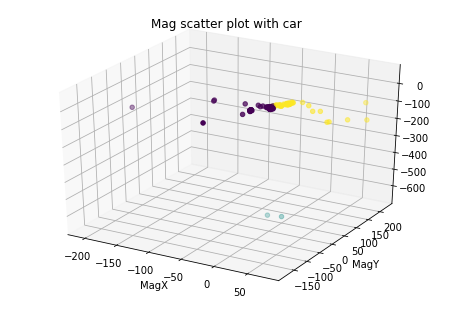

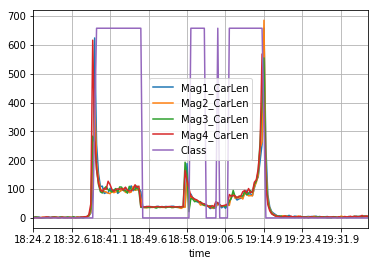

In [3]:
def csv_file_get_key(csv_name, key):
    strlist = csvFile.replace("."," ").replace(","," ").replace("_"," ").split(" ")
    return strlist[key]

def prase_node_data(df, mag_number, csv_path, csvFile):
    namelist = df.columns
    feature_name = ['Mag_CarLen', 'Mag_CarX','Mag_CarY','Mag_CarZ',
    'Mag_EnvX','Mag_EnvY','Mag_EnvZ','Mag_Len','Mag_X','Mag_Y','Mag_Z']
    
    for i in range(mag_number):
        mag_df = pd
        mag_start = namelist.get_loc("Mag" + str(i+1) + "_CarLen")
        mag_end   = namelist.get_loc("Mag" + str(i+1) + "_Z")    
        mag_df    = df.iloc[:,:namelist.get_loc("Forward") +1 ]
        mag_df["Sideway"] = df["Sideway"]
        mag_df["time"] = df["time"]
        mag_df[feature_name] = df[namelist[mag_start:mag_end+1]]
        csvFilepath = csv_path + "Mag"+ str(i+1) + "_"+ csvFile
#         print(csvFilepath)
        mag_df.to_csv(csvFilepath)
    
def get_algorithm_feature(df):

    EnvX = df['Mag_EnvX'][0]
    EnvY = df['Mag_EnvY'][0]
    EnvZ = df['Mag_EnvZ'][0]
    Detection = Car_Detection(EnvX, EnvY, EnvZ)
    
    # implement detection method(10)
    df["Mag_Zcompoment_norm"] = df.apply(lambda row: Detection.detect_1_Zcompoment_norm(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_performance_XY_plane"] = 500 * df.apply(lambda row: Detection.detect_2_performance_XY_plane(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_cosine_variations_product_XY_plane"] = df.apply(lambda row: Detection.detect_3_cosine_variations_product_XY_plane(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_cosine_variations_Kcriterion"] = df.apply(lambda row: Detection.detect_4_cosine_variations_Kcriterion(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_square_deviation"] = df.apply(lambda row: Detection.detect_5_square_deviation(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_vectorial_deviation"] = 1000 * df.apply(lambda row: Detection.detect_6_vectorial_deviation(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_combined_vectorial_deviation"] = 1000 * df.apply(lambda row: Detection.detect_7_combined_vectorial_deviation(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_weighting_vectorial_deviation"] = 1000 * df.apply(lambda row: Detection.detect_8_weighting_vectorial_deviation(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_each_axis_difference"] = df.apply(lambda row: Detection.detect_9_each_axis_difference(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_each_axis_distance"] = df.apply(lambda row: Detection.detect_10_each_axis_distance(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)

    return df


# for csvFile in csvFiles:
csvFile = csvFiles[1]
car_category = csv_file_get_key(csvFile, 1)
print(car_category)
# car_category = "tercel"
car_brand = "nisson"

csvRawDataName = Rawdata_folderName + csvFile
csvNewDataName = Newdata_folderName + "New_" + csvFile

# can change by string funciton
if csvFile.find("back") != -1:
    car_in_out_type = "Backward"
elif csvFile.find("forward") != -1:
    car_in_out_type = "Forward"
elif csvFile.find("side") != -1:
    car_in_out_type = "Sideway"

Experiment_Mag_number = 4
Experiment_Mag_Env_number = 10


df = pd.read_csv(csvRawDataName)
df = get_mag_len(df, Experiment_Mag_number)
df = get_mag_env(df, Experiment_Mag_number, Experiment_Mag_Env_number)
df = get_mag_car_field(df, Experiment_Mag_number)
df = get_car_brand(df, car_brand, car_category)
df = get_car_in_out_type(df, car_in_out_type)

# clustering
Kmean_feature = ["Mag1_CarX","Mag1_CarY","Mag1_CarZ"]
df = get_kmean_label(df, Kmean_feature)
df = df[sorted(df.columns)]
df.to_csv(csvNewDataName)

plt.figure(); 
df.plot(x='time', y=['Mag1_CarLen','Mag2_CarLen','Mag3_CarLen','Mag4_CarLen', 'Class'], grid = True);
        

In [4]:
csvNewFiles = [f for f in listdir(Newdata_folderName) if isfile(join(Newdata_folderName, f)) and f[-3:] == "csv" ]

for csvFile in csvNewFiles:
    csvName = Newdata_folderName + csvFile
    df_new = pd.read_csv(csvName, index_col = 0 )
    prase_node_data(df_new, 4, Prasedata_folderName, csvFile)

## test algorithm 

train_data :  (299, 25)
target_data:  (299,)


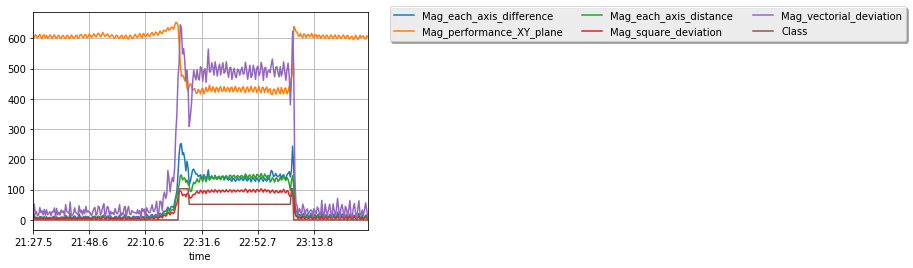

In [5]:
def get_algorithm_feature(df):

    EnvX = df['Mag_EnvX'][0]
    EnvY = df['Mag_EnvY'][0]
    EnvZ = df['Mag_EnvZ'][0]
    Detection = Car_Detection(EnvX, EnvY, EnvZ)
    
    # implement detection method(10)
    df["Mag_Zcompoment_norm"] = df.apply(lambda row: Detection.detect_1_Zcompoment_norm(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_performance_XY_plane"] = 500 * df.apply(lambda row: Detection.detect_2_performance_XY_plane(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_cosine_variations_product_XY_plane"] = df.apply(lambda row: Detection.detect_3_cosine_variations_product_XY_plane(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_cosine_variations_Kcriterion"] = df.apply(lambda row: Detection.detect_4_cosine_variations_Kcriterion(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_square_deviation"] = df.apply(lambda row: Detection.detect_5_square_deviation(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_vectorial_deviation"] = 1000 * df.apply(lambda row: Detection.detect_6_vectorial_deviation(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_combined_vectorial_deviation"] = 1000 * df.apply(lambda row: Detection.detect_7_combined_vectorial_deviation(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_weighting_vectorial_deviation"] = 1000 * df.apply(lambda row: Detection.detect_8_weighting_vectorial_deviation(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_each_axis_difference"] = df.apply(lambda row: Detection.detect_9_each_axis_difference(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)
    df["Mag_each_axis_distance"] = df.apply(lambda row: Detection.detect_10_each_axis_distance(row['Mag_X'], row['Mag_Y'], row['Mag_Z']), axis = 1)

    return df

Mag_csvFiles = [f for f in listdir(Prasedata_folderName) if isfile(join(Prasedata_folderName, f)) and f[-3:] == "csv"]
Mag_csvFiles.sort()

Mag_csvFile = Prasedata_folderName + Mag_csvFiles[0]
mag_df = pd.read_csv(Mag_csvFile, index_col = 0 )
mag_df = get_algorithm_feature(mag_df)

feature_start_index = mag_df.columns.get_loc("Mag_CarLen") 
feature_list = list(mag_df.columns[feature_start_index:]) 
train_data  = mag_df[feature_list]
target_data = mag_df["Class_Target"]
print("train_data : ", train_data.shape)
print("target_data: ", target_data.shape)

mag_df.plot(x = 'time', y = ['Mag_each_axis_difference', 'Mag_performance_XY_plane',
    'Mag_each_axis_distance', 'Mag_square_deviation','Mag_vectorial_deviation',
    'Class'
], grid = True)
plt.legend(bbox_to_anchor = (1.05, 1.05), ncol = 3, fancybox = True, shadow = True)


## b0.2 algorithm

In [6]:
def get_car_algorithm(df):
    Detection = detect_algorithm()
    Mag_detect_rate = []
    Mag_detect_sendflag = []
    Mag_detect_status = []
    Mag_detect_envbias = []
    Mag_detect_score = []
    
    MagRawdata = mag_df[["Mag_X", "Mag_Y","Mag_Z"]].values.tolist()

    for Rawdata in MagRawdata: 
        Mag_detect_rate.append(Detection.Get_VehicleDetection_Rate(Rawdata))
        Mag_detect_sendflag.append(Detection.Get_VehicleDetection_SendData())
        Mag_detect_status.append(Detection.Get_VehicleDetection_Status())
        Mag_detect_envbias.append(Detection.Get_VehicleDetection_EnvBias())
        Mag_detect_score.append(Detection.Get_VehicleDetection_Score())
        
    df["Mag_detect_rate"]     = Mag_detect_rate
    df["Mag_detect_sendflag"] = Mag_detect_sendflag
    df["Mag_detect_status"]   = Mag_detect_status
    df["Mag_detect_envbias"]  = Mag_detect_envbias
    df["Mag_detect_score"]  = Mag_detect_score
    max_value = df["Mag_CarLen"].max()/2
    df["Mag_detect_status_show"]   = [ x * max_value for x in Mag_detect_status ]

    return df

for csvFile in Mag_csvFiles:
    Mag_csvFile = Prasedata_folderName + csvFile
    mag_df = pd.read_csv(Mag_csvFile, index_col = 0 )
    mag_df = get_algorithm_feature(mag_df)
    mag_df = get_car_algorithm(mag_df)
#     mag_df.to_csv(Mag_csvFile)
    
#     print("\n-----------------------", csvFile, "---------------------- ")
    mag_df.plot(x = 'time', y = ['Mag_square_deviation', 
    'Class', 'Mag_detect_status_show', 'Mag_detect_score'
    ], grid = True)
    plt.legend(bbox_to_anchor = (1.05, 1.05), ncol = 3, fancybox = True, shadow = True)


NameError: name 'MageEnv_Len' is not defined

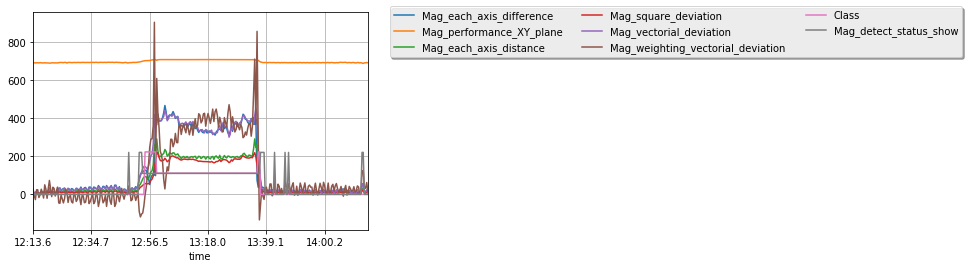

In [9]:
mag_df.plot(x = 'time', y = ['Mag_each_axis_difference', 'Mag_performance_XY_plane',
    'Mag_each_axis_distance', 'Mag_square_deviation','Mag_vectorial_deviation', "Mag_weighting_vectorial_deviation",
    'Class', 'Mag_detect_status_show'
], grid = True)
plt.legend(bbox_to_anchor = (1.05, 1.05), ncol = 3, fancybox = True, shadow = True)



## test all csv

In [7]:
feature_sum = []

for csvFile in Mag_csvFiles:
    Mag_csvFile = Prasedata_folderName + csvFile
    mag_df = pd.read_csv(Mag_csvFile, index_col = 0 )
    mag_df = get_algorithm_feature(mag_df)
    mag_df.to_csv(Mag_csvFile)
#     print("----- ", csvFile, "-----")
    feature_start_index = mag_df.columns.get_loc("Mag_Zcompoment_norm")
    feature_end_index = mag_df.columns.get_loc("Mag_each_axis_distance") + 1
#     feature_start_index = mag_df.columns.get_loc("Mag_CarLen") 
    feature_list  = [ 'Mag_CarX', 'Mag_CarY', 'Mag_CarZ']
    feature_list += list(mag_df.columns[feature_start_index:feature_end_index]) 
    train_data    = mag_df[feature_list]
    target_data   = mag_df["Class_Target"]
    
    print("\n-----------------------", csvFile, "---------------------- ")
#     print(mag_df.columns)
    model_RandomForest  = set_Training_RandomForest(train_data, target_data)
    feature_filter = get_FeatureImportance(model_RandomForest, feature_list, 0.05)
    feature_sum += feature_filter
    
    
feature_sum.sort()
feature_type_count = [[feature_sum.count(x),x] for x in set(feature_sum)]
feature_type_count.sort(reverse=True)
feature_type_count[:10]


----------------------- Mag1_New_clotplus_back_in.csv ---------------------- 
Test Model Score:  0.988888888889
Click Rate:  37.7926421405 %
Feature ranking:
1. feature 4 - Mag_performance_XY_plane (0.174003)
2. feature 0 - Mag_CarX (0.169313)
3. feature 11 - Mag_each_axis_difference (0.108988)
4. feature 9 - Mag_combined_vectorial_deviation (0.092024)
5. feature 6 - Mag_cosine_variations_Kcriterion (0.086584)
6. feature 7 - Mag_square_deviation (0.083851)
7. feature 12 - Mag_each_axis_distance (0.079012)
8. feature 3 - Mag_Zcompoment_norm (0.071891)
9. feature 2 - Mag_CarZ (0.053414)

----------------------- Mag1_New_clotplus_forward_in.csv ---------------------- 
Test Model Score:  0.991379310345
Click Rate:  20.7792207792 %
Feature ranking:
1. feature 11 - Mag_each_axis_difference (0.251384)
2. feature 1 - Mag_CarY (0.185200)
3. feature 7 - Mag_square_deviation (0.142780)
4. feature 3 - Mag_Zcompoment_norm (0.086967)
5. feature 0 - Mag_CarX (0.076670)
6. feature 12 - Mag_each_axis_


----------------------- Mag2_New_tercel_forward_in.csv ---------------------- 
Test Model Score:  1.0
Click Rate:  38.5416666667 %
Feature ranking:
1. feature 4 - Mag_performance_XY_plane (0.164203)
2. feature 10 - Mag_weighting_vectorial_deviation (0.145014)
3. feature 6 - Mag_cosine_variations_Kcriterion (0.128696)
4. feature 7 - Mag_square_deviation (0.118738)
5. feature 8 - Mag_vectorial_deviation (0.110458)
6. feature 9 - Mag_combined_vectorial_deviation (0.096890)
7. feature 12 - Mag_each_axis_distance (0.083174)
8. feature 5 - Mag_cosine_variations_product_XY_plane (0.076816)
9. feature 1 - Mag_CarY (0.054352)

----------------------- Mag3_New_clotplus_back_in.csv ---------------------- 
Test Model Score:  0.977777777778
Click Rate:  37.7926421405 %
Feature ranking:
1. feature 7 - Mag_square_deviation (0.206308)
2. feature 0 - Mag_CarX (0.193514)
3. feature 12 - Mag_each_axis_distance (0.169049)
4. feature 11 - Mag_each_axis_difference (0.077575)
5. feature 2 - Mag_CarZ (0.0661


----------------------- Mag4_New_tercel_backward_in.csv ---------------------- 
Test Model Score:  1.0
Click Rate:  30.0 %
Feature ranking:
1. feature 8 - Mag_vectorial_deviation (0.169738)
2. feature 12 - Mag_each_axis_distance (0.136772)
3. feature 4 - Mag_performance_XY_plane (0.135522)
4. feature 7 - Mag_square_deviation (0.132344)
5. feature 1 - Mag_CarY (0.124617)
6. feature 11 - Mag_each_axis_difference (0.107822)

----------------------- Mag4_New_tercel_forward_in.csv ---------------------- 
Test Model Score:  0.988505747126
Click Rate:  38.5416666667 %
Feature ranking:
1. feature 5 - Mag_cosine_variations_product_XY_plane (0.243945)
2. feature 12 - Mag_each_axis_distance (0.130483)
3. feature 7 - Mag_square_deviation (0.127643)
4. feature 8 - Mag_vectorial_deviation (0.125621)
5. feature 4 - Mag_performance_XY_plane (0.122627)
6. feature 1 - Mag_CarY (0.116921)
7. feature 11 - Mag_each_axis_difference (0.072587)


[[28, 'Mag_each_axis_distance'],
 [26, 'Mag_square_deviation'],
 [26, 'Mag_each_axis_difference'],
 [21, 'Mag_combined_vectorial_deviation'],
 [21, 'Mag_CarY'],
 [20, 'Mag_performance_XY_plane'],
 [19, 'Mag_weighting_vectorial_deviation'],
 [19, 'Mag_cosine_variations_Kcriterion'],
 [17, 'Mag_vectorial_deviation'],
 [16, 'Mag_Zcompoment_norm']]

## test  csv with top 5 feature

In [ ]:
feature_list = [each[1] for each in feature_type_count ][:5]
feature_sum = []

for csvFile in Mag_csvFiles:
    Mag_csvFile = Prasedata_folderName + csvFile
    mag_df = pd.read_csv(Mag_csvFile, index_col = 0 )
    mag_df = get_algorithm_feature(mag_df)
    mag_df.to_csv(Mag_csvFile)

    train_data  = mag_df[feature_list]
    target_data = mag_df["Class_Target"]
    
    print("\n-----------------------", csvFile, "---------------------- ")
#     print(mag_df.columns)
    model_RandomForest  = set_Training_RandomForest(train_data, target_data)
    feature_filter = get_FeatureImportance(model_RandomForest, feature_list, 0.05)
    feature_sum += feature_filter
    
feature_sum.sort()
feature_type_count = [[feature_sum.count(x),x] for x in set(feature_sum)]
feature_type_count.sort(reverse=True)
feature_type_count[:5]

## Random Forest

In [3]:
# model_RandomForest  = set_Training_RandomForest(train_data, target_data)
# # model_LogisticRegression = set_Training_LogisticRegression(train_data, target_data)

# get_FeatureImportance(model_RandomForest, feature_list)
# get_FeatureImportance_Boxplot(model_RandomForest, feature_list)